### Names of Students and ID: Hendrik und Lennard
### Group number: H

# Clustering of image data with Mixture Models


We saw in the last project that mixture models / k-means are a powerful way to detect groups in multidimensional real data. However, mixture models can be easily generalized to other types of data.
The goal of the project is to implement a mixture model that can cluster image data using a mixture of bernoulli distributions.
This jupyter notebook will serve as a guide for the different steps of the implementation of the model and of its estimation. In the last part we will try to apply our model to recover missing part of an image! This is also called imputation.

You will find expected outputs throughout the notebook that should match your output for the same example input, given the correct implementation of the function bodys.

`Note:` Throughout the notebook you will find docstrings describing the in and output of the different functions, these are meant as hints to guide during the implementation. Whether you meet the exact type or not is up to you and will not be graded as long as your implementation returns the expected result. If your implementation is slow it might be sufficient to use half of the dataset for good results.

### For grading, you are just expected to fill in this notebook. Feel free to add text answers within the notebook whenever appropriate.

#### Have fun!

In [79]:
# Here are some helpful packages to solve this exercise
# You might need to restart the notebook kernel for these to be available for import after the installation
# The tensorflow package is only needed to load the MNIST datasets. You can avoid to installing it if you
# plan to download the table on your own.
!uv pip install tensorflow

!uv pip install matplotlib
!uv pip install numpy
!uv pip install scipy
!uv pip install plotly
!uv pip install scikit-learn
!uv pip install nbformat

Audited 1 package in 17ms
Audited 1 package in 5ms
Audited 1 package in 1ms
Audited 1 package in 3ms
Audited 1 package in 2ms
Audited 1 package in 3ms
Audited 1 package in 5ms


# Know your data
Have a look at the `MNIST` data set below; Get familiar with how the data is structured, this will be important for later excercises as well!

We will use prepared versions of the datasets that are already available in [Keras](https://keras.io/getting_started/). You will need to install `keras` with `Tensorflow`. Alternatively there are also tabular versions to download on Kaggle of the [digit](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) and the [fashion](https://www.kaggle.com/datasets/zalando-research/fashionmnist) datasets.

In [80]:
import keras
from keras.datasets import mnist
import numpy as np

(X_train, Y_train), (test_X, test_y) = mnist.load_data()
X_train = np.concatenate([X_train, test_X], axis=0)
Y_train = np.concatenate([Y_train, test_y], axis=0)
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))

example_1_X = X_train[8]
example_3_X = X_train[7]
example_7_X = X_train[40000]
example_7_y = Y_train[40000]
example_8_X = X_train[17]
print(f"This is a 7: \n{example_7_y}")
print(f"And it has shape: \n{example_7_X.shape}")
print(f"This is a 7's image data: \n{example_7_X}")

X_train: (70000, 28, 28)
Y_train: (70000,)
This is a 7: 
7
And it has shape: 
(28, 28)
This is a 7's image data: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   5   4   7  

### 1) Get familiar with the dataset by plotting some of the $x_i$ in $X_{\text{train}}$.

From the last section you might have seen that the value matrices $x \in \mathbb{N}^{d\times d} $ are actually 2D numpy arrays of shape (d, d). These resemble the pixels in the image, where each value indicates the respective pixels intensity.

Have a look at how this translates into the actual image by plotting some examples below, this will come in handy later on!


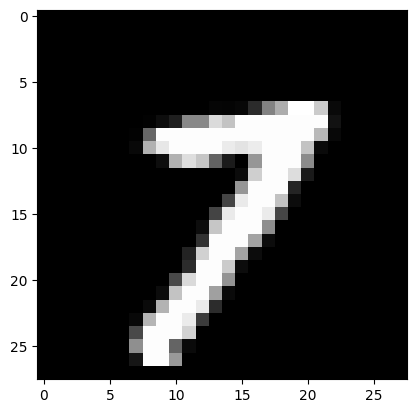

In [81]:
import matplotlib.pyplot as plt

# Plot some examples from X_train using matplotlib
plt.imshow(example_7_X, cmap = 'grey')

## 2) Preprocessing

You can see in the plot that the value matrices of the different $x$ contain values $\in \{0, 1, ..., 255\}$, representing pixel intensity on the grey scale. However, we want to reduce dimensionality for this project and transform all values to be in ${0,1}$ while keeping a meaningful representation of the original image. This will help us later when we want to think more in terms of probabilities, e.g., the probability for a pixel being on (white) given its image class. We can then model each pixel as an independant Bernoulli for our approximation. In addition, we will later work on (flattened matrices) vectors $\vec{v} \in \mathbb{N}^{d*d}$ instead of matrices $x \in \mathbb{N}^{d\times d}$.

2.a) Implement the fuction body of `binarize_image()` that flattens a given input matrix of dimension $d \times d$ and returns a binarized vector of dimension $d^2$, given a binarization `threshold`.

In [82]:
def binarize_image(xi_mat: np.ndarray, threshold: int = 127):
  """
  Convert 2D value matrix of shape (d, d) of greyscale image to 1D binary vector of shape (d * d).

  Parameters
  ----------
  xi_mat : np.ndarray
      A 2D NumPy array of shape (d, d) representing a grayscale image,
      where each element is a pixel intensity value between 0 and 255.

  threshold: int
      Decision threshold value above which all pixel values are set to 1,
      below (or equal to) which they are set to 0. Default is 127.

  Returns
  -------
  xi_bin_vec : np.array
      A 1D NumPy array of shape (d * d) representing the binary vector
      of the input image, where each element is either 0 or 1 (binary vector).
  """
  # Your code goes here

  xi_bin_vec = np.array(xi_mat).flatten()
  return np.where(xi_bin_vec > threshold, 1, 0)


test_mat = np.array([
    [0, 127, 255],
    [255, 128, 0],
    [0, 126, 255]
])

test_mat = np.array([
       [ 80,  80,   0,   0,  80,   0,   0,  80,  80,  80],
       [ 80,   0, 255, 255,   0, 255, 255,   0,  80,  80],
       [ 80,   0, 255, 255, 255,   0, 255,   0,  80,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192,  50, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80]
])

test_bin_vec = np.array([0, 0, 1, 1, 1, 0, 0, 0, 1])

test_bin_vec = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
                         1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                         0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
                         1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Check if your function returns the expected result by comparing the matrices below
print(f"Expected binarized vector:\n{test_bin_vec}")
print(f"Binarized vector with your implementation:\n{binarize_image(test_mat)}")

assert np.array_equal(binarize_image(test_mat), test_bin_vec), "Binarized vector returned by your implementation is not equal to the expected vector."

Expected binarized vector:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Binarized vector with your implementation:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Printed matrices are nice, but you can never _bee_ too sure with these things.

#### 2.b) Implement the helper function `recover_image_matrix()` to recover a binarized matrix from the vector. Plot the binarized representation matrix and have a look at how the figure changed!

After running the code on the `test_mat`, feel free to look at some other examples in the `MNIST` dataset. What do you observe?

In [83]:
def recover_image_matrix(xi_bin_vec: np.ndarray, d: int = 28):
  """
  Convert 1D binary vector of shape (d * d) to 2D binary matrix of shape (d, d) of the image.

  Parameters
  ----------
  xi_bin_vec : np.array
      A 1D NumPy array of shape (d * d) representing the binary representation
      of the input image, where each element is either 0 or 1.

  d : int
      The dimension of the square matrix to be recovered.

  Returns
  -------
  xi_bin_mat : np.ndarray
      A 2D NumPy array of shape (d, d) representing the grayscale image,
      where each element is either 0 or 1 (binary matrix).
  """

  # Your code goes here
  xi_bin_mat = np.array(xi_bin_vec).reshape(d, d)
  return xi_bin_mat


test_bin_mat = np.array([
    [0, 0, 1],
    [1, 1, 0],
    [0, 0, 1]
])

test_bin_mat = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

print(f"Expected binarized matrix:\n{test_bin_mat}")
print(f"Binarized matrix with your implementation:\n{recover_image_matrix(test_bin_vec, 10)}")

assert np.array_equal(recover_image_matrix(test_bin_vec, 10), test_bin_mat), "Binarized matrix returned by your implementation is not equal to the expected matrix."


Expected binarized matrix:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Binarized matrix with your implementation:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


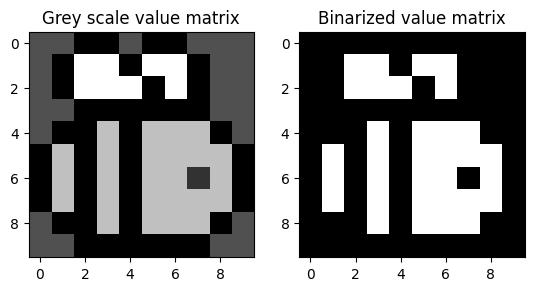

In [84]:
plt.subplot(1, 2, 1)
plt.imshow(test_mat, cmap = 'grey')
plt.title("Grey scale value matrix")
plt.subplot(1, 2, 2)
plt.imshow(test_bin_mat, cmap = 'grey')
plt.title("Binarized value matrix")
plt.show()


> What do you observe? -> When the image is transformed with binarize_image(), it loses its details because it only allows two values: white and black.



## 3) Class representatives

Let's get back to the `MNIST` dataset. This dataset was prepared for a supervised learning task. For each $x \in X_{\text{train}}$ we have a label $y \in Y_{\text{train}}$. We can partition $X_{\text{train}}$ into $|C|$ subsets that correspond to the images for each of the digits ($X^{(1)}$ are all the samples for digit $1$, $X^{(2)}$ for digit $2$, and so on).

$X^{(c)} = \{x \in X_{\text{train}} \mid y = c\}, \text{ with } c \in C = \{0,...9\}$

### 3.a) Compute a representative vector for a given class.
Apply the binary matrix transformations from earlier sections to the training dataset and implement the function body for `compute_class_representative()` that computes a representative value vector (flattened matrix) for a set of input matrices. Then use this function to compute representatives for $c = \{1,3,8\}$.
In this case you can think of the representative value matrix (or vector) as a matrix (or vector) in which each value resembles the probability of the corresponding pixel being white (= a value of 1). This probability is computed given all matrices (or vectors) of that class. You will compute a maximum a posteriori estimate. You may use pseudo-counts if neccessary.


`Note:` For simplicity we assume that pixels in the image data are independent of each other. Can you think of a reason why we do this?



*Can you think of a reason why we do this? ->  Independence simplifies the calculation because each pixel can be considered individually. Normally, however, pixels are not independent. Nevertheless, this simplification allows us to achieve faster results, even if they are not perfect.*



In [113]:
def compute_class_repesentative_probs(X_c: np.ndarray, X_c_probs: np.ndarray, pseudo_count = 1e-3):
    X_c = X_c.astype(float)
    X_c += pseudo_count
    X_c *= X_c_probs.reshape(-1,1)
    return np.sum(X_c, axis=0) / np.sum(X_c_probs)

Expected representative matrix: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]
Representative matrix with your implementation: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]


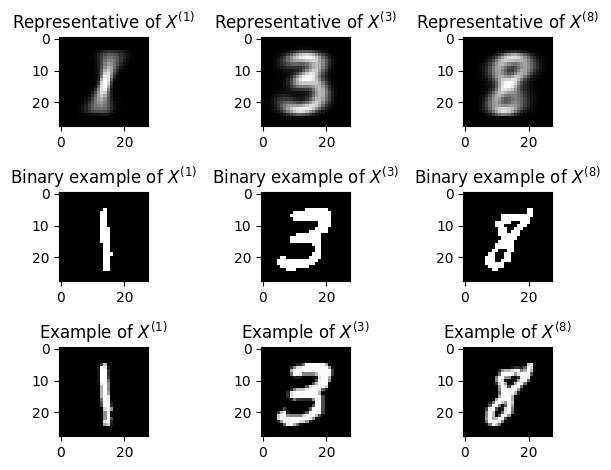

In [86]:
def compute_class_representative(X_c: np.ndarray, pseudo_count = 1e-3):
  """
  Compute a representative value matrix for a set of input matrices.

  Parameters
  ----------
  X_c : np.ndarray
      2D array of binarized input vectors of shape (num_samples, d).
  pseudo_count: float
      pseudo count to be added to each pixel value.

  Returns
  -------
  class_representative : np.array
      1D array (n_features,) representing the class representative vector.
  """
  # Your code here

  class_representative = X_c.mean(0)
  class_representative += pseudo_count

  return class_representative



test_X_c = np.random.default_rng(161).integers(0, 2, (25, 24))
test_representative = np.array([0.441, 0.681, 0.641, 0.601, 0.321, 0.521, 0.401, 0.521, 0.481, 0.561, 0.561, 0.481, 0.481, 0.641, 0.481, 0.321, 0.481, 0.521, 0.481, 0.521, 0.441, 0.601, 0.601, 0.401])

print(f"Expected representative matrix: \n{test_representative}")
print(f"Representative matrix with your implementation: \n{compute_class_representative(test_X_c)}")

assert np.array_equal(compute_class_representative(test_X_c), test_representative), "Class representative matrix returned by your implementation is not equal to the expected class representative matrix."

# Once you implemented the function body above, create subsets X_1, X_3, X_8
# from X_train and compute their representative vectors and plot them below. Use
# appropriate transformation to get back to plotable matrix data with correct
# dimensions.

# Apply binarization
X_train_bin = np.array([binarize_image(x) for x in X_train])

# Compute representatives
representative_X_1_vec = compute_class_representative(X_train_bin[Y_train == 1])
representative_X_3_vec = compute_class_representative(X_train_bin[Y_train == 3])
representative_X_8_vec = compute_class_representative(X_train_bin[Y_train == 8])

# Make plotable
representative_X_1_mat = recover_image_matrix(representative_X_1_vec, 28)
representative_X_3_mat = recover_image_matrix(representative_X_3_vec, 28)
representative_X_8_mat = recover_image_matrix(representative_X_8_vec, 28)

# Binarize examples
example_1_X_bin_vec = binarize_image(example_1_X)
example_3_X_bin_vec = binarize_image(example_3_X)
example_8_X_bin_vec = binarize_image(example_8_X)

# Make plotable
example_1_X_bin_mat = recover_image_matrix(example_1_X_bin_vec, 28)
example_3_X_bin_mat = recover_image_matrix(example_3_X_bin_vec, 28)
example_8_X_bin_mat = recover_image_matrix(example_8_X_bin_vec, 28)

plt.subplot(3, 3, 1)
plt.imshow(representative_X_1_mat, cmap = 'grey')
plt.title("Representative of $X^{(1)}$")
plt.subplot(3, 3, 2)
plt.imshow(representative_X_3_mat, cmap = 'grey')
plt.title("Representative of $X^{(3)}$")
plt.subplot(3, 3, 3)
plt.imshow(representative_X_8_mat, cmap = 'grey')
plt.title("Representative of $X^{(8)}$")

plt.subplot(3, 3, 4)
plt.imshow(example_1_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(1)}$")
plt.subplot(3, 3, 5)
plt.imshow(example_3_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(3)}$")
plt.subplot(3, 3, 6)
plt.imshow(example_8_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(8)}$")

plt.subplot(3, 3, 7)
plt.imshow(example_1_X, cmap = 'grey')
plt.title("Example of $X^{(1)}$")
plt.subplot(3, 3, 8)
plt.imshow(example_3_X, cmap = 'grey')
plt.title("Example of $X^{(3)}$")
plt.subplot(3, 3, 9)
plt.imshow(example_8_X, cmap = 'grey')
plt.title("Example of $X^{(8)}$")
plt.tight_layout()
plt.show()

## Computing vector probabilities

#### 3.b) Write a function that computes the log probability for a set of binarized vectors

It will take as input a set of input vectors $X$ you derived from the set of `MNIST` image matrices $X_{\text{test}}$, a class representative $\vec{\mu}_c$. Be careful not to take the logarithm of zero (to avoid that we add a parameter $\varepsilon$ to the function).

Later we can use this to compute for example:

$$
\log \mathbb{P} (\vec{v} \mid y = c) = \sum_{j=1}^{784} v_j\cdot \log(\mu_{c,j}) + (1-v_j)\cdot \log (1-\mu_{c,j})
$$

In [87]:
def log_probabilities(X, class_representative, eps = 1e-7):
    """
    Compute log P(x_i | y=c) for binary X under independent Bernoulli pixels.

    Parameters
    ----------
    X : array-like, shape (n_samples, d)
        Binary inputs (0/1). If floats, values are interpreted as probabilities but should be 0/1.
    class_representative : array-like, shape (d,)
        Per-pixel probability of 1 (values in [0,1]).
    eps: float
        minimum value for the probability of a pixel to be observed (to avoid rounding errors).

    Returns
    -------
    log_probas : np.ndarray, shape (n_samples,)
        Log-likelihoods for each sample.
    """
    # Your code here

    p = np.clip(class_representative, eps, 1.0 - eps)

    log_probas = np.matmul(X, np.log(p)) + np.matmul((1 - X), np.log(1 - p))
    return log_probas



test_log_probas = np.array([-87.87645595, -100.75135407, -74.28714557, -82.9868483, -86.35217585, -164.77564207, -79.17198904, -95.40878212])
your_log_probas = log_probabilities(X_train_bin[Y_train == 1][:8], compute_class_representative(X_train_bin[Y_train == 1][:8], 0))

print(f"Expected log probabilities:\n{test_log_probas}")
print(f"Log probabilities with your implementation:\n{your_log_probas}")

Expected log probabilities:
[ -87.87645595 -100.75135407  -74.28714557  -82.9868483   -86.35217585
 -164.77564207  -79.17198904  -95.40878212]
Log probabilities with your implementation:
[ -87.87651022 -100.75140834  -74.28719984  -82.98690257  -86.35223012
 -164.77569634  -79.17204331  -95.40883639]


## Compute the class posteriors

### 3.c) Implement `compute_class_posteriors`.

This function takes as argument a set of representatives, and the class priors and returns a matrix of all the class posterior for each image vector in the input. You can use the function `log_probabilities()` to simplify the computation. You might also want to consider the log-sum-exp transformation to improve the numerical stability of your calculations where appropriate (there is for instance a `scipy.special.logsumexp()` function).


In [146]:
from scipy.special import logsumexp

def compute_class_posteriors(X, class_representative_lst, priors_lst):
    """
    Compute class posterior probabilities P(c_k | v_i).

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors, one per class.

    priors_lst : list or np.ndarray
        Class priors P(c_k), should sum to 1.


    Returns
    -------
    posteriors : np.ndarray
        Array of shape (num_samples, num_classes) contining the posterior P(c_k | x_i) for each class c_k and vector v_i
    """

    log_priors = np.log(np.array(priors_lst))
    log_likelihoods = np.zeros((len(X), len(class_representative_lst)))
    # Your code here

    # Compute log P(x_i | C_k) for each class
    for k in range(len(class_representative_lst)):
      log_likelihoods[:,k] = log_probabilities(X, class_representative_lst[k])

    # Add log priors
    log_likelihoods = log_likelihoods + log_priors

    # Normalize
    return np.exp(log_likelihoods - logsumexp(log_likelihoods, axis=1, keepdims=True))


representatives_lst = [representative_X_1_vec, representative_X_3_vec, representative_X_8_vec]
X = np.array([example_1_X_bin_vec, example_3_X_bin_vec, example_8_X_bin_vec])
priors = [0.1, 0.3, 0.6]

class_posteriors = compute_class_posteriors(X, representatives_lst, priors)

expected_class_posteriors = np.array([
    [1.00000000e+00, 1.43676230e-34, 2.25592315e-33],
    [1.36608608e-89, 9.99947360e-01, 5.26398117e-05],
    [8.79971746e-23, 1.49211952e-27, 1.00000000e+00],
  ])

print(f"Expected class posteriors:\n{expected_class_posteriors}")
print(f"Class posteriors with your implementation:\n{class_posteriors}")

Expected class posteriors:
[[1.00000000e+00 1.43676230e-34 2.25592315e-33]
 [1.36608608e-89 9.99947360e-01 5.26398117e-05]
 [8.79971746e-23 1.49211952e-27 1.00000000e+00]]
Class posteriors with your implementation:
[[1.00000000e+00 1.29831447e-34 1.93616038e-33]
 [2.60350399e-87 9.99946590e-01 5.34102768e-05]
 [2.02362596e-22 1.82580602e-27 1.00000000e+00]]


## 3.d) Compute the conditional log-likelihood of the vectors

Compute the conditional log-likelihood of the vectors by integrating over all possible class membership (note that you will have to compute an exponential of the log-probabilities computed with the previous function, again the log-sum-exp transformation might come in handy here).
$$
\log P(x_1,\ldots, x_n \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) =
\sum_{i=1}^n \log \Big(\sum_{k=1}^K \pi_k P(x_i \mid z_i = k)\Big)
$$
`Note:` $z_i$ is the latent (non observed) variable that corresponds to the class of the vector $x_i$

In [147]:
def conditional_log_likelihood(X, class_representative_lst, priors_lst):
    """
    Compute the conditional log-likelihood of each vector x_i
    by marginalizing over all class memberships.

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors (means for each class).

    priors_lst : list or np.ndarray
        Class prior probabilities P(C_k), should sum to 1.

    Returns
    -------
    cond_log_likelihood : np.ndarray
        1D array of conditional log-likelihoods log P(x_i) for each sample.
    """
    # Your code here
    log_priors = np.log(np.array(priors_lst))
    log_likelihoods = np.zeros((len(X), len(class_representative_lst)))

    for k in range(len(class_representative_lst)):
        log_likelihoods[:,k] = log_probabilities(X, class_representative_lst[k])

    log_likelihoods = log_likelihoods + log_priors

    return logsumexp(log_likelihoods, axis=1)


cond_log_likelihood = conditional_log_likelihood(X, representatives_lst, priors)

expected_cond_log_likelihood = np.array([ -87.52055809, -178.60050244, -158.62268905])


print(f"Expected conditional log-likelihoods:\n{expected_cond_log_likelihood}")
print(f"Conditional log-likelihoods with your implementation:\n{cond_log_likelihood}")



Expected conditional log-likelihoods:
[ -87.52055809 -178.60050244 -158.62268905]
Conditional log-likelihoods with your implementation:
[ -87.52055809 -178.60050244 -158.62268905]


## 4) Estimating class representatives and implementing EM _light_

In the following we will implement a simplified version of EM with binary class allocations (each sequence is in the class where it has the highest posterior probability).

We will first write a function for the E-step, then a function for the M-step, and finally combine them to EM-light.


#### 4.a) Write a function for computing the E-step of the EM algorithm

From set of vectors, class representatives and priors, we compute first compute the class posteriors and then assign clusters to the input vectors. Then compute the conditional log likelihood to track convergence.



In [148]:
def E_step(X, class_representatives_lst, priors_lst):
    """
    Performs the E-step of a simplified EM lite algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    representatives : list of np.ndarray
        Current class representative vectors (means or prototypes).
    priors : np.ndarray
        Current class prior probabilities, shape (n_classes,).

    Returns
    -------
    assignments : np.ndarray
        Hard class assignments (argmax over posterior probabilities), shape (n_samples,).
    cond_log_likelihood : np.ndarray
        Conditional log-likelihoods log P(X), shape (n_samples,).
    """
    # Your code here

    # Calculate repsonsibilities
    class_posteriors = compute_class_posteriors(X, class_representatives_lst, priors_lst)
    # Hard assign
    class_assignments = np.argmax(class_posteriors, axis=1)
    # Compute conditional log-likelihoods
    conditional_likelihood = conditional_log_likelihood(X, class_representatives_lst, priors_lst)
    # For tracking convergence
    return class_assignments, conditional_likelihood



assignments, cond_log_likelihoods = E_step(X, representatives_lst, priors)

In [149]:
def E_step_prob(X, class_representatives_lst, priors):

    class_posteriors = compute_class_posteriors(X, class_representatives_lst, priors)
    # Hard assign
    class_assignments = np.argmax(class_posteriors, axis=1)
    # Compute conditional log-likelihoods
    conditional_likelihood = conditional_log_likelihood(X, class_representatives_lst, priors)
    # For tracking convergence
    return class_posteriors, class_assignments, conditional_likelihood

posteriors_p,assignments_p, cond_log_likelihoods_p = E_step_prob(X, representatives_lst, priors)
print(posteriors_p)


[[1.00000000e+00 1.29831447e-34 1.93616038e-33]
 [2.60350399e-87 9.99946590e-01 5.34102768e-05]
 [2.02362596e-22 1.82580602e-27 1.00000000e+00]]


#### 4.b) Write a function for computing the M-step of the EM algorithm

From set of vectors, cluster assignments from the E-step, and a given number of clusters K, update the class representatives and priors.



In [150]:
def M_step(X, assignments, K):
    """
    Performs the M-step of the simplified EM algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    assignments : np.ndarray
        Hard class assignments (output of E-step), shape (n_samples,).
    K : int
        Number of classes (clusters).

    Returns
    -------
    representatives : list of np.ndarray
        Updated class representatives (mean vectors for each class).
    priors : np.ndarray
        Updated class prior probabilities (frequency of each class).
    """

    n_samples = len(X)
    representatives = np.array([compute_class_representative(X[np.where(assignments == i)]) for i in range(K)])
    priors = np.array([len(np.where(assignments == i)[0]) / n_samples for i in range(K)])

    return representatives, priors


class_representatives_lst, priors_lst = M_step(X, assignments, 3)
print(priors_lst)

[0.33333333 0.33333333 0.33333333]


In [151]:
def M_step_prob(X, posteriors, hard_assignments, K):
    n_samples = len(X)
    # representatives = np.array([compute_class_representative(X[np.where(hard_assignments == i)]) for i in range(K)])
    representatives = np.array([compute_class_repesentative_probs(X, posteriors[:,i], 0) for i in range(K)])
    non_normalized_priors = np.sum(posteriors, axis=0)
    priors = non_normalized_priors / np.sum(non_normalized_priors)

    return representatives, priors

class_representatives_lst_p, priors_lst_p = M_step_prob(X, posteriors_p, assignments_p, 3)
print(priors_lst_p)


[0.33333333 0.33331553 0.33335114]


#### 4.c) Implementing EM

We will implement the EM algorithm with fixed class allocation:

1. Fix the number of clusters $K$. In the next part, we first will try two values: $K=10$ and $K=20$.
2. Initialize random allocation of the representative. The most common way is to sample the $K$ representative from the set of points at random, however you can also use e.g.: `kmeans++` for better initialization, which can lead to faster convergence (there are some libraries implementing `kmeans++` that you can use).
3. Until convergence
    - run E-step
    - run M-step (update representatives and priors)
    - check if convergence criteria is met (change in max nll or min ll is smaller than tolerance threshold `tol`) or maximum number of iterations it reached





In [152]:
from sklearn.cluster import kmeans_plusplus

def EM(X, K, max_iter=100, tol=1e-4):
    """
    Simplified EM (hard assignment) algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features).
    K : int
        Number of classes.
    max_iter : int, optional
        Maximum number of EM iterations.
    tol : float, optional
        Convergence tolerance for change in log-likelihood.

    Returns
    -------
    class_representatives_lst : list of np.ndarray
        Estimated class representative vectors.
    priors : np.ndarray
        Estimated class priors.
    assignments : np.ndarray
        Hard assignments for each sample.
    log_likelihoods : list of float
        Log-likelihood at each iteration.
    """

    # Init
    centers, indices = kmeans_plusplus(X, n_clusters=K, random_state = 42)

    priors = [1 / K for _ in range(K)]
    class_representatives = X[indices]
    assignments = np.zeros(X.shape[0])
    likelihoods = []

    for i in range(max_iter):
        new_assignments, log_likelihood = E_step(X, class_representatives, priors)
        assignments = new_assignments
        likelihoods.append(log_likelihood)
        new_reprs, new_priors = M_step(X, assignments, K)
        class_representatives = new_reprs
        priors = new_priors
        if (len(likelihoods) > 1):
          if (abs(np.min(log_likelihood) - np.min(likelihoods[i - 1])) < tol):
            break

    return class_representatives, priors, assignments, likelihoods


In [153]:
def EM_prob(X, K, max_iter=100, tol=1e-4):
    centers, indices = kmeans_plusplus(X, n_clusters=K, random_state = 42)

    priors = [1 / K for _ in range(K)]
    class_representatives = X[indices]
    assignments = np.zeros(X.shape[0])
    likelihoods = []

    for i in range(max_iter):
        posteriors, new_assignments, log_likelihood = E_step_prob(X, class_representatives, priors)
        assignments = new_assignments
        likelihoods.append(log_likelihood)
        new_reprs, new_priors = M_step_prob(X, posteriors, assignments, K)
        class_representatives = new_reprs
        priors = new_priors
        if (len(likelihoods) > 1):
          if (abs(np.min(log_likelihood) - np.min(likelihoods[i - 1])) < tol):
            break

    return class_representatives, priors, assignments, likelihoods

In [35]:
K = 10
K = 20
N = 6000

class_representatives_lst, priors_lst, assignments, log_likelihoods = EM(X_train_bin[:N], K)

## 5) Evaluation

Evaluating the quality of a clustering is always a complex task. In the case of the digit data, we can compare it to the digit allocation in order to assess if some clusters are better defined than others.

In this part we will perform some simple evaluation and visualization for the typical clustering we obtained in the previous part (*e.g.* with $K=10$ and $K=20$ clusters).

One measure that can be computed in the case where class membership are available is the **purity**. The purity is a measure of how much of a cluster describes a single class. It is defined for each cluster $C_k$ as the proportion accounted by the majority class.
$$
\text{purity}(C_k) = \frac{1}{C_k}\; \max_{c=0,\ldots, 9} \quad \sum_{i=1}^{n} \mathbb{I}\{x_i \in C_k; y_i = c\}
$$


### 5.a) Plot the representative for each cluster
- How does the representatives looks like for $K=10$ clusters? Is it a sufficient number of clusters? How can you explain that?
- In the case of $K=20$, do you see any digits that seem to be spread across multiple cluster? How do you explain that?



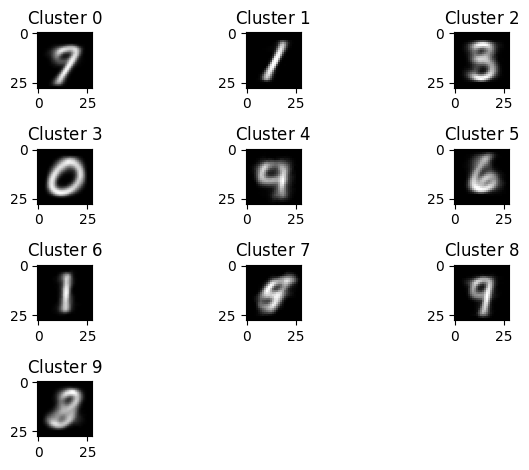

In [154]:
### K = 10
K = 10
class_representatives_lst_10, priors_lst_10, assignments_10, log_likelihoods_10 = EM(X_train_bin[:N], K)

for k in range(K):
  ## Plot the representative for each cluster
  cluster_mat = recover_image_matrix(class_representatives_lst_10[k], 28)

  plt.subplot(4,3,k + 1)
  plt.imshow(cluster_mat, cmap ='grey')
  plt.title(f"Cluster ${k}$")

plt.tight_layout()
plt.show()





*Is it a sufficient number of clusters? How can you explain that? -> Some numbers can be assigned to clear clusters, such as 0, 1, or 6. However, there are also clusters that include several numbers; in this case, more clusters would be appropriate in order to distinguish them further.*



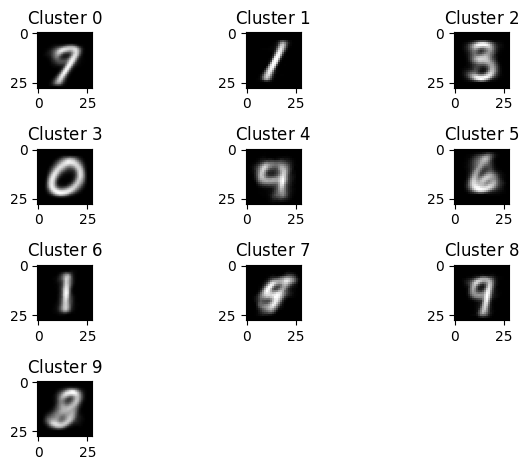

In [155]:
### K = 10
K = 10
class_representatives_lst_10_p, priors_lst_10_p, assignments_10_p, log_likelihoods_10_p = EM_prob(X_train_bin[:N], K)

for k in range(K):
  ## Plot the representative for each cluster
  cluster_mat = recover_image_matrix(class_representatives_lst_10_p[k], 28)

  plt.subplot(4,3,k + 1)
  plt.imshow(cluster_mat, cmap ='grey')
  plt.title(f"Cluster ${k}$")

plt.tight_layout()
plt.show()

In [129]:
print(np.sum(log_likelihoods_10[-1]))
print(np.sum(log_likelihoods_10_p[-1]))

-984831.299701429
-982780.3241964681


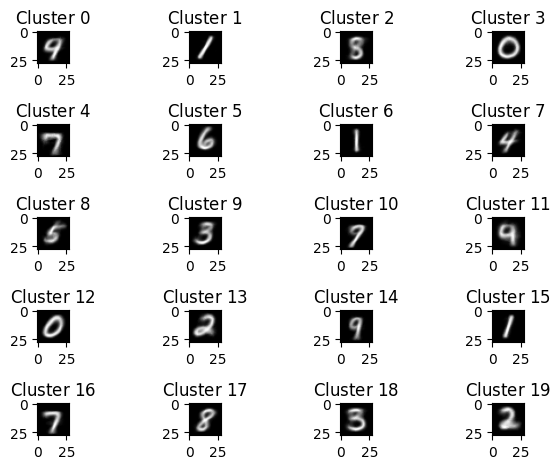

In [130]:
### K = 10
K = 20
class_representatives_lst_20, priors_lst_20, assignments_20, log_likelihoods_20 = EM(X_train_bin[:N], K)

for k in range(K):
  ## Plot the representative for each cluster
  cluster_mat = recover_image_matrix(class_representatives_lst_20[k], 28)

  plt.subplot(5,4,k + 1)
  plt.imshow(cluster_mat, cmap ='grey')
  plt.title(f"Cluster ${k}$")

plt.tight_layout()
plt.show()

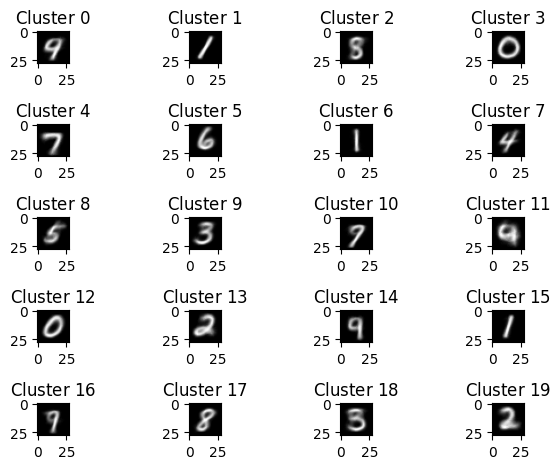

In [133]:
### K = 10
K = 20
class_representatives_lst_20_p, priors_lst_20_p, assignments_20_p, log_likelihoods_20_p = EM_prob(X_train_bin[:N], K, 200)

for k in range(K):
  ## Plot the representative for each cluster
  cluster_mat = recover_image_matrix(class_representatives_lst_20_p[k], 28)

  plt.subplot(5,4,k + 1)
  plt.imshow(cluster_mat, cmap ='grey')
  plt.title(f"Cluster ${k}$")

plt.tight_layout()
plt.show()

In [166]:
print(-np.sum(log_likelihoods_20[-1]))
print(-np.sum(log_likelihoods_20_p[-1]))

906759.265558244
900053.9811380394


In [161]:
import plotly.graph_objects as go

p_plot = go.Figure(data=go.Scatter(x=[k for k in range(len(log_likelihoods_20_p))], y=np.sum(log_likelihoods_20_p, axis=1)))
n_plot = go.Figure(data=go.Scatter(x=[k for k in range(len(log_likelihoods_20))], y=np.sum(log_likelihoods_20, axis=1)))
p_plot.show()
n_plot.show()



*In the case of K=20, do you see any digits that seem to be spread across multiple cluster? How do you explain that? -> At K=20, the clusters are more diverse with clear numbers, but there are also clusters that cover the same numbers. There are also still clusters that cover several numbers. Since there are only 10 numbers and 20 clusters, it is logical that numbers are divided among several clusters.*





### 5.b) Compute the purity for each cluster

For both $K=10$ and $K=20$, look at the clusters that get the best or the worst purity.
- Are they associated with particular digits?
- How could you explain that?

In [38]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix

def per_cluster_purity(y_true, y_pred, K):
  purity = [0] * K
  cluster_sizes = [0] * K
  for i in range(K):
    assigned_to_cluster = y_true[np.where(y_pred == i)[0]]
    cluster_sizes[i] = len(assigned_to_cluster)
    mx = np.max([len(np.where(assigned_to_cluster == j)[0]) for j in range(10)])
    purity[i] = mx / cluster_sizes[i]

  return purity, cluster_sizes

In [39]:
# K = 10
K = 10

purity, sizes = per_cluster_purity(Y_train[:N], assignments_10,K)
print(f"Clusters with max purity: {np.argmax(purity)} ({np.max(purity)})")
print(f"Clusters with min purity: {np.argmin(purity)} ({np.min(purity)})")
for j, (p, n) in enumerate(zip(purity, sizes)):
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_10)
print(f"ARI: {ari}")

Clusters with max purity: 3 (0.9483471074380165)
Clusters with min purity: 9 (0.3329326923076923)
Cluster 0: purity=0.600, size=530
Cluster 1: purity=0.947, size=359
Cluster 2: purity=0.422, size=823
Cluster 3: purity=0.948, size=484
Cluster 4: purity=0.413, size=542
Cluster 5: purity=0.695, size=764
Cluster 6: purity=0.665, size=475
Cluster 7: purity=0.387, size=568
Cluster 8: purity=0.348, size=623
Cluster 9: purity=0.333, size=832
ARI: 0.3393762531296017


In [163]:
K = 10

purity, sizes = per_cluster_purity(Y_train[:N], assignments_10_p,K)
print(f"Clusters with max purity: {np.argmax(purity)} ({np.max(purity)})")
print(f"Clusters with min purity: {np.argmin(purity)} ({np.min(purity)})")
for j, (p, n) in enumerate(zip(purity, sizes)):
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_10_p)
print(f"ARI: {ari}")

Clusters with max purity: 3 (0.95)
Clusters with min purity: 9 (0.30339805825242716)
Cluster 0: purity=0.615, size=517
Cluster 1: purity=0.949, size=353
Cluster 2: purity=0.437, size=792
Cluster 3: purity=0.950, size=480
Cluster 4: purity=0.398, size=545
Cluster 5: purity=0.636, size=824
Cluster 6: purity=0.659, size=481
Cluster 7: purity=0.371, size=572
Cluster 8: purity=0.353, size=612
Cluster 9: purity=0.303, size=824
ARI: 0.33323842016830485




*Are they associated with particular digit? How could you explain that? -> Purity is highest for clusters 1 and 3, which represent the numbers 1 and 0. This is probably because these numbers have certain characteristics that make them particularly easy to distinguish and classify. There is overlap in the other clusters because they are similar to each other, such as the numbers 6, 8, and 9.*



In [164]:
# K = 20
K = 20

purity, sizes = per_cluster_purity(Y_train[:N], assignments_20,K)
print(f"Clusters with max purity: {np.argmax(purity)} ({np.max(purity)})")
print(f"Clusters with min purity: {np.argmin(purity)} ({np.min(purity)})")
for j, (p, n) in enumerate(zip(purity, sizes)):
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_20)
print(f"ARI: {ari}")

Clusters with max purity: 12 (0.9675090252707581)
Clusters with min purity: 2 (0.40497737556561086)
Cluster 0: purity=0.512, size=248
Cluster 1: purity=0.966, size=206
Cluster 2: purity=0.405, size=442
Cluster 3: purity=0.936, size=264
Cluster 4: purity=0.907, size=108
Cluster 5: purity=0.944, size=446
Cluster 6: purity=0.914, size=267
Cluster 7: purity=0.857, size=203
Cluster 8: purity=0.540, size=367
Cluster 9: purity=0.678, size=360
Cluster 10: purity=0.607, size=377
Cluster 11: purity=0.418, size=447
Cluster 12: purity=0.968, size=277
Cluster 13: purity=0.921, size=227
Cluster 14: purity=0.474, size=409
Cluster 15: purity=0.889, size=235
Cluster 16: purity=0.953, size=214
Cluster 17: purity=0.841, size=302
Cluster 18: purity=0.547, size=300
Cluster 19: purity=0.930, size=301
ARI: 0.36040663096683573


In [165]:
# K = 20
K = 20

purity, sizes = per_cluster_purity(Y_train[:N], assignments_20_p,K)
print(f"Clusters with max purity: {np.argmax(purity)} ({np.max(purity)})")
print(f"Clusters with min purity: {np.argmin(purity)} ({np.min(purity)})")
for j, (p, n) in enumerate(zip(purity, sizes)):
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_20_p)
print(f"ARI: {ari}")

Clusters with max purity: 4 (0.9827586206896551)
Clusters with min purity: 11 (0.32710280373831774)
Cluster 0: purity=0.494, size=259
Cluster 1: purity=0.977, size=215
Cluster 2: purity=0.420, size=441
Cluster 3: purity=0.942, size=226
Cluster 4: purity=0.983, size=174
Cluster 5: purity=0.919, size=459
Cluster 6: purity=0.925, size=253
Cluster 7: purity=0.862, size=195
Cluster 8: purity=0.558, size=362
Cluster 9: purity=0.761, size=343
Cluster 10: purity=0.631, size=379
Cluster 11: purity=0.327, size=321
Cluster 12: purity=0.955, size=313
Cluster 13: purity=0.895, size=247
Cluster 14: purity=0.455, size=308
Cluster 15: purity=0.876, size=241
Cluster 16: purity=0.410, size=371
Cluster 17: purity=0.805, size=303
Cluster 18: purity=0.481, size=293
Cluster 19: purity=0.909, size=297
ARI: 0.35658758751868724


*Are they associated with particular digit? How could you explain that? -> Purity is highest for clusters 1, 3, 5, 6, 12, 13, 16, and 19, which represent the numbers 1, 0, 6, 1, 0, 2, 7, and 2. Overall, purity has increased in all clusters, as the multiple clusters provide more opportunities to represent characteristics of the numbers and make them easier to separate. However, some numbers are still easier to classify than others.*

## 5.c) Using Sankey Plot

[Sankey plots](https://en.wikipedia.org/wiki/Sankey_diagram) can summarize visually how globally digit identity are spread around clusters. Create a Sankey plot that matches the digits labels to the cluster allocation. In other words we will show how the digits (labelled from the _ground truth_ `Y_train`) flow into the different clusters. You can limit yourself to the case of $K=20$ for this representation.

 - Consider one of the clusters with the highest purity, can you see it in the Sankey plot?
 - Is there a digit that is reliably represented by only one cluster?
 - If not how many clusters are needed at minimum to represent all instances of a digit? Which digits are concerned in that case?

In [157]:
## Plotly provides the easiest method for obtaining sankey plot with interactive visualization
import plotly.graph_objects as go
import plotly.io as pio

#pio.renderers.default = 'browser'

y_true = np.array(Y_train[:6000])
cluster_assignments = np.array(assignments_20)

true_labels = np.unique(y_true)
cluster_labels = np.unique(cluster_assignments)

source_labels = [f"Label {t}" for t in true_labels]
target_labels = [f"Cluster {c}" for c in cluster_labels]
all_labels = source_labels + target_labels

# Match labels and create Sankey plot
source_indices = []
target_indices = []
values = []

for i in range(len(true_labels)):
    for j in range(len(cluster_labels)):
        count_ij = np.sum((y_true == true_labels[i]) & (cluster_assignments == cluster_labels[j]))
        source_indices.append(i)
        target_indices.append(j + len(true_labels))
        values.append(count_ij)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = all_labels,
      color = "blue"
    ),
    link = dict(
      source = source_indices,
      target = target_indices,
      value = values
  ))])

fig.show()




*Consider one of the clusters with the highest purity, can you see it in the Sankey plot? -> Clusters 1, 3, 5, 6, 12, 13, 16, and 19 with high purity mostly represent only one label, with a few outliers.*

*Is there a digit that is reliably represented by only one cluster? -> The number 6 is almost covered by a cluster, but not quite. There are often 2-3 larger clusters and a few outliers.*

*If not how many clusters are needed at minimum to represent all instances of a digit? Which digits are concerned in that case? -> Usually, 2-3 clusters are needed for a number, with a few outliers.*


## 6. The agony of choice (for a good $K$)

In this part we will see how we can use measures such as dispersion of likelihood to decide a good number of clusters $K$.

#### 6.a) Find a good number of clusters computationally.

The negative log likelihood (`nll`) and / or the within-cluster variance can be good indicators to select the number of cluster. We will consider different values of $k$ (from 2 to 20) and monitor how the `nll` or the variance changes. We will also see how the number of cluster affect the runtime of the EM-light algorithm.  Plot and describe your findings.

- Run the mixture model for different values of $k$ from $2$ to $20$ or more and plot the `nll` as a function of $k$. Plot as well the running time of EM as a function of $k$.
- Propose the best value for $k$, justify your choice. What about the resulting groups, are they very diverse?

#### 6.b) Comparing the best results

Using a Sankey plot with 3 components, represent the class allocation together with the clustering of the best value of $K$ and a value of $K=20$.

In [170]:
import time
import plotly.express as px
max_nll_lst, time_lst = [], []

Kmax = 20

for i in range(2, Kmax + 1):
  start = time.time()
  repr, prir, assign, likeli = EM(X_train_bin[:4000], i)
  end = time.time()
  max_nll_lst.append(-np.sum(likeli[-1]))
  time_lst.append(end - start)

nll_plot = go.Figure(data=go.Scatter(x=[k for k in range(2, Kmax +1)], y=max_nll_lst))
time_plot = go.Figure(data=go.Scatter(x=[k for k in range(2, Kmax + 1)], y=time_lst))

nll_plot.show()
time_plot.show()



First Plot: nll

Second Plot: time

In [171]:
import time
import plotly.express as px
max_nll_lst, time_lst = [], []

Kmax = 20

for i in range(2, Kmax + 1):
  start = time.time()
  repr, prir, assign, likeli = EM_prob(X_train_bin[:N], i)
  end = time.time()
  max_nll_lst.append(-np.sum(likeli[-1]))
  time_lst.append(end - start)

nll_plot = go.Figure(data=go.Scatter(x=[k for k in range(2, Kmax +1)], y=max_nll_lst))
time_plot = go.Figure(data=go.Scatter(x=[k for k in range(2, Kmax + 1)], y=time_lst))

nll_plot.show()
time_plot.show()

*Plot and describe your findings.->Different values for K result in different classification speeds, and the negative log likelihood decreases slightly with higher k values. However, this decrease is more pronounced at the beginning, so we decided on 13 as a good compromise between time and nll.*

In [172]:
class_representatives_lst, priors_lst, assignments_best, log_likelihoods = EM(X_train_bin[:N], 13)
class_representatives_lst, priors_lst, assignments_k20, log_likelihoods = EM(X_train_bin[:N], 20)

In [173]:
y_true = np.array(Y_train[:6000])
cluster_assignments_best = np.array(assignments_best)
cluster_assignments_k20 = np.array(assignments_k20)

true_labels = np.unique(y_true)
cluster_labels_best = np.unique(cluster_assignments_best)
cluster_labels_k20 = np.unique(cluster_assignments_k20)

source_labels = [f"Label {t}" for t in true_labels]
labels_best = [f"Cluster {c}" for c in cluster_labels_best]
labels_k20 = [f"Cluster {c}" for c in cluster_labels_k20]
all_labels = source_labels + labels_best + labels_k20

# Match labels and create Sankey plot
source_indices = []
target_indices = []
values = []

for i in range(len(true_labels)):
    for j in range(len(cluster_labels_best)):
        count_ij = np.sum((y_true == true_labels[i]) & (cluster_assignments_best == cluster_labels_best[j]))
        source_indices.append(i)
        target_indices.append(j + len(true_labels))
        values.append(count_ij)

for i in range(len(cluster_labels_best)):
    for j in range(len(cluster_labels_k20)):
        count_ij = np.sum((cluster_assignments_best == cluster_labels_best[i]) & (cluster_assignments_k20 == cluster_labels_k20[j]))
        source_indices.append(i + len(true_labels))
        target_indices.append(j + len(true_labels) + len(cluster_labels_best))
        values.append(count_ij)

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict( width = 0.5),
      label = all_labels,
    ),
    link = dict(
      source = source_indices,
      target = target_indices,
      value = values
  ))])

fig.show()


## 7) Data Imputation
### Oh no! Part of the image got overwritten with `512` values! Can we recover the digit pictured on the image with our trained mixture model?

As we saw during the lecture, clustering is also a way of producing simplified representations of the data points (albeit somehow crude). We will see in the following if we can use the information in the representative to reconstruct part of the image that would have been masked.

Below you will find our example image vectors, each masked with `512`s for some predetermined positions between pixels 100 and 400. This leaves us with some visible pixels $x_{vis}$ and some 'missing' (masked) pixels $x_{miss}$.

We want to compute a probability for the image to below of each of the class, given the visible pixels $x_{vis}$. Then, we can reconstruct each pixel as a posterior value over all possible class allocations.

1. Implement the function `em_impute`, that computes the posterior probabilities to belong to each class $c$ given the visible pixels of the image, given the results of the EM-lite run:

$$
p(z = c \mid x_{vis})
$$

2. Then for each missing pixel $x_j$ impute its expected value given the model parameters we trained:
$$
\mathbb{E}[x_j \mid x_{vis}] = \sum_{k=1}^{K}p(z = c_k \mid x_{vis})\cdot \mu_{k,j}
$$

1. (optional) Imagine we want to consider those 3 images with missing pixel for the estimation of the parameters. Is it possible to write a version of the EM algorithm that would take into account those images with missing values? What are the changes for the E-step and the M-step in that case?


#### 7.a) Implement `em_impute()` that takes a masked image vector, the respective mask, a set of representatives and a set of priors as input and outputs a recovered image vector with imputed values at the positions of the mask.

#### 7.b) Plot the imputed images for example 1,3, and 8 with `mask1` and `mask2` respectively. Comment on the quality of the reconstruction depending on the digit and the mask used. How would you assess the quality of the reconstruction in a more systematic way?


`Note:` You might want to make use of `log_probabilities()`, `compute_class_posteriors()`, and `binarize_image()` functions again.
Can you get away without calling `binarize_image()`? What do you observe?

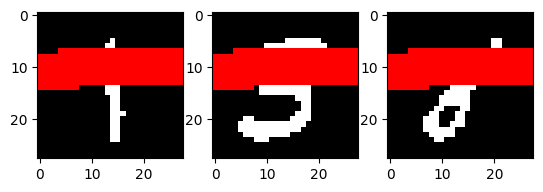

In [174]:

from matplotlib.colors import ListedColormap, BoundaryNorm

example_1_masked = example_1_X_bin_vec.copy().astype('uint16')
example_3_masked = example_3_X_bin_vec.copy().astype('uint16')
example_8_masked = example_8_X_bin_vec.copy().astype('uint16')
mask1 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask2 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask1[200:400] = False
mask2[200:600] = False
example_1_masked[~mask1] = 512
example_3_masked[~mask1] = 512
example_8_masked[~mask1] = 512

example_1_masked2 = example_1_X_bin_vec.copy().astype('uint16')
example_3_masked2 = example_3_X_bin_vec.copy().astype('uint16')
example_8_masked2 = example_8_X_bin_vec.copy().astype('uint16')
example_1_masked2[~mask2] = 512
example_3_masked2[~mask2] = 512
example_8_masked2[~mask2] = 512

cmap = ListedColormap(['black', 'white', 'red'])
norm = BoundaryNorm([0, 0.5, 1.5, 512.5], cmap.N)

plt.subplot(1,3,1)
plt.imshow(recover_image_matrix(example_1_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,2)
plt.imshow(recover_image_matrix(example_3_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,3)
plt.imshow(recover_image_matrix(example_8_masked), cmap = cmap, norm=norm)
plt.show()

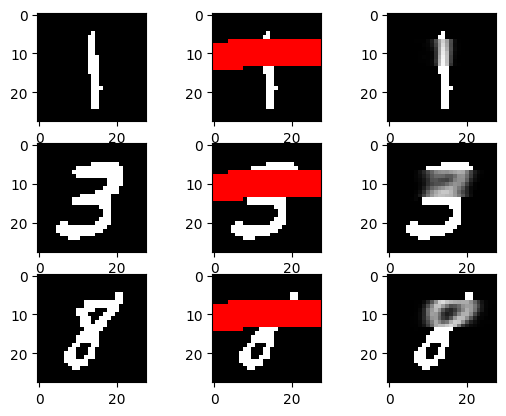

In [175]:
def em_impute(x_masked, mask, class_representatives, class_priors, K = 10):
    """
    Imputes missing (masked) pixels in x_masked using parameters retrived by EM-light.

    Parameters
    ----------
    X_masked : np.ndarray, shape (num_samples, d)
        Each row is a flattened image (some pixels missing or zeroed)
    mask : np.ndarray, shape (d,)
        Boolean array: True for observed pixels, False for missing ones
    class_representatives : np.ndarray, shape (K, d)
        Mean vectors estimated by EM (μ_k)
    class_priors : np.ndarray, shape (K,)
        Prior probabilities for each class (π_k)

    Returns
    -------
    X_imputed : np.ndarray, shape (n_samples, d)
        Reconstructed images with missing pixels imputed.
    """

    class_representatives = np.array(class_representatives)
    x_masked = np.array(x_masked).astype(float)
    # Visible pixels
    x_vis = x_masked[mask]
    #Your code here
    visible_representatives = [rep[mask] for rep in class_representatives]
    posteriors = compute_class_posteriors(x_vis, visible_representatives, class_priors)

    X_imputed = x_masked
    masked_pixels = np.where(mask == False)

    for index in masked_pixels[0]:
      expected_val = np.sum([posteriors[0][i] * class_representatives[i][index] for i in range(K)])
      X_imputed[index] = np.clip(expected_val, 0, 1)

    return X_imputed

class_representatives_lst, priors_lst, assignments, log_likelihoods
example_1_imputed = em_impute(example_1_masked, mask1, class_representatives_lst, priors_lst, K = 20)
example_3_imputed = em_impute(example_3_masked, mask1, class_representatives_lst, priors_lst, K = 20)
example_8_imputed = em_impute(example_8_masked, mask1, class_representatives_lst, priors_lst, K = 20)


plt.subplot(3,3,1)
plt.imshow(example_1_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,2)
plt.imshow(recover_image_matrix(example_1_masked), cmap = cmap, norm=norm)
plt.subplot(3,3,3)
plt.imshow(recover_image_matrix(example_1_imputed), cmap = 'grey')

plt.subplot(3,3,4)
plt.imshow(example_3_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,5)
plt.imshow(recover_image_matrix(example_3_masked), cmap = cmap, norm=norm)
plt.subplot(3,3,6)
plt.imshow(recover_image_matrix(example_3_imputed), cmap = 'grey')

plt.subplot(3,3,7)
plt.imshow(example_8_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,8)
plt.imshow(recover_image_matrix(example_8_masked), cmap = cmap, norm=norm)
plt.subplot(3,3,9)
plt.imshow(recover_image_matrix(example_8_imputed), cmap = 'grey')
plt.show()


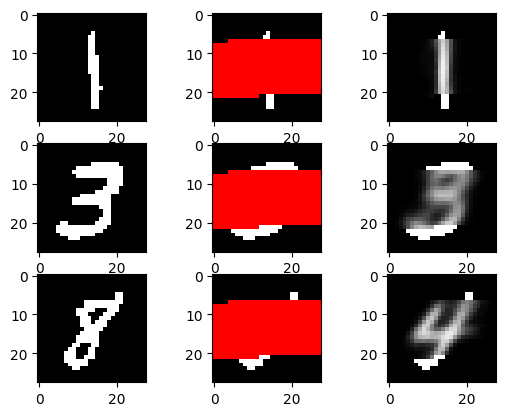

In [176]:
class_representatives_lst, priors_lst, assignments, log_likelihoods
example_1_imputed = em_impute(example_1_masked2, mask2, class_representatives_lst, priors_lst, K = 20)
example_3_imputed = em_impute(example_3_masked2, mask2, class_representatives_lst, priors_lst, K = 20)
example_8_imputed = em_impute(example_8_masked2, mask2, class_representatives_lst, priors_lst, K = 20)

plt.subplot(3,3,1)
plt.imshow(example_1_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,2)
plt.imshow(recover_image_matrix(example_1_masked2), cmap = cmap, norm=norm)
plt.subplot(3,3,3)
plt.imshow(recover_image_matrix(example_1_imputed), cmap = 'grey')

plt.subplot(3,3,4)
plt.imshow(example_3_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,5)
plt.imshow(recover_image_matrix(example_3_masked2), cmap = cmap, norm=norm)
plt.subplot(3,3,6)
plt.imshow(recover_image_matrix(example_3_imputed), cmap = 'grey')

plt.subplot(3,3,7)
plt.imshow(example_8_X_bin_mat, cmap = 'grey')
plt.subplot(3,3,8)
plt.imshow(recover_image_matrix(example_8_masked2), cmap = cmap, norm=norm)
plt.subplot(3,3,9)
plt.imshow(recover_image_matrix(example_8_imputed), cmap = 'grey')
plt.show()

*What do you observe? -> It is possible to determine correct numbers and correct the image even with missing pixels. Without binarization, it becomes visible at which points the classification is reliable. However, if too much information is missing, as in the second case, this is not possible, but it would certainly be difficult for a human being as well*

*We could test the quality of the reconstructed image in a more systematic way, if we had a classifyer for the MNIST data set. With this, we could take some images, mask them, reconstruct them and then measure, how many of them were recognized as the original digit by our classifier. With this we can judge, how well our reconstruction is recognizable and how often we reconstructed something that actually resembled the original.*

## 7) One size _fits_ all? (Bonus)

Enough with all these numbers and digits! Around 2018, Zalando research proposed a new [`fashion-MNIST`](https://github.com/zalandoresearch/fashion-mnist) dataset which consider images of fashion items. This dataset contains as well 10 classes and 60,000 examples.It can be easily imported from the `keras` package.

- Load the dataset and see how our model works on this dataset too!
  - What is the effect of the binarization of the images in part 2?
  - You can go over parts 4.c) to 6) on this dataset and analyze the results.
- Does the Bernoulli mixture fits to this dataset?
- Do you have to retrain the model parameters? What do you see?


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 22s 1us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(60000, 28, 28)

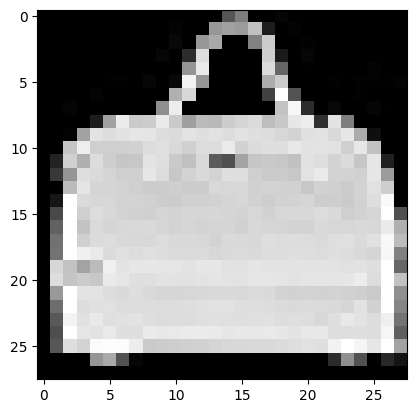

In [27]:
from keras.datasets import fashion_mnist

(F_train, E_train), (test_F, test_e) = fashion_mnist.load_data()

# You code here

example_Fashion = F_train[220]

plt.imshow(example_Fashion, cmap = 'grey')
F_train.shape

In [28]:
F_train_bin = np.array([binarize_image(x) for x in F_train])

repr, priors, assignments, lls = EM(F_train_bin[:N], 20)



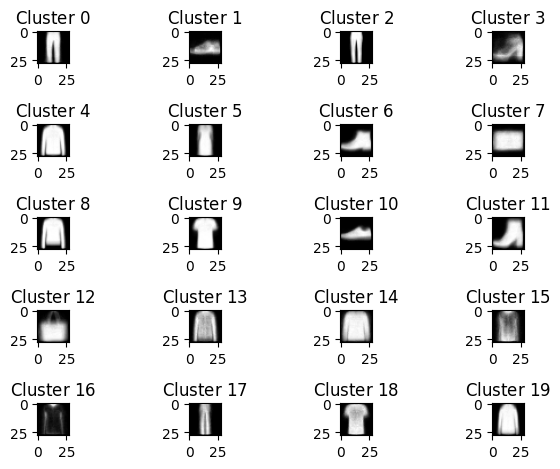

In [34]:
### K = 10
K = 20
for k in range(K):
  ## Plot the representative for each cluster
  cluster_mat = recover_image_matrix(repr[k], 28)

  plt.subplot(5,4,k + 1)
  plt.imshow(cluster_mat, cmap ='grey')
  plt.title(f"Cluster ${k}$")

plt.tight_layout()
plt.show()
